In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/80 [..............................] - ETA: 1:40 - loss: 0.0391 - STD: 2.9248e-04 - MAE: 0.1892

 4/80 [>.............................] - ETA: 2s - loss: 0.0270 - STD: 3.0871e-04 - MAE: 0.1247  

 5/80 [>.............................] - ETA: 2s - loss: 0.0270 - STD: 3.2249e-04 - MAE: 0.1238

 6/80 [=>............................] - ETA: 2s - loss: 0.0260 - STD: 3.5420e-04 - MAE: 0.1193

 7/80 [=>............................] - ETA: 3s - loss: 0.0245 - STD: 4.0273e-04 - MAE: 0.1120

 8/80 [==>...........................] - ETA: 3s - loss: 0.0230 - STD: 4.6273e-04 - MAE: 0.1060

 9/80 [==>...........................] - ETA: 3s - loss: 0.0219 - STD: 5.2834e-04 - MAE: 0.1041

10/80 [==>...........................] - ETA: 3s - loss: 0.0213 - STD: 5.9584e-04 - MAE: 0.1049

11/80 [===>..........................] - ETA: 3s - loss: 0.0210 - STD: 6.6062e-04 - MAE: 0.1062

12/80 [===>..........................] - ETA: 3s - loss: 0.0206 - STD: 7.2105e-04 - MAE: 0.1068

13/80 [===>..........................] - ETA: 3s - loss: 0.0201 - STD: 7.7701e-04 - MAE: 0.1060

14/80 [====>.........................] - ETA: 3s - loss: 0.0195 - STD: 8.2653e-04 - MAE: 0.1040

15/80 [====>.........................] - ETA: 3s - loss: 0.0190 - STD: 8.6944e-04 - MAE: 0.1013

16/80 [=====>........................] - ETA: 3s - loss: 0.0186 - STD: 9.0822e-04 - MAE: 0.0988

17/80 [=====>........................] - ETA: 3s - loss: 0.0184 - STD: 9.4351e-04 - MAE: 0.0966

18/80 [=====>........................] - ETA: 3s - loss: 0.0181 - STD: 9.7694e-04 - MAE: 0.0947

19/80 [======>.......................] - ETA: 3s - loss: 0.0179 - STD: 0.0010 - MAE: 0.0930    

20/80 [======>.......................] - ETA: 3s - loss: 0.0177 - STD: 0.0010 - MAE: 0.0914

21/80 [======>.......................] - ETA: 3s - loss: 0.0175 - STD: 0.0011 - MAE: 0.0899

22/80 [=======>......................] - ETA: 3s - loss: 0.0172 - STD: 0.0011 - MAE: 0.0886

23/80 [=======>......................] - ETA: 3s - loss: 0.0170 - STD: 0.0012 - MAE: 0.0877

24/80 [========>.....................] - ETA: 3s - loss: 0.0168 - STD: 0.0013 - MAE: 0.0871

25/80 [========>.....................] - ETA: 3s - loss: 0.0166 - STD: 0.0013 - MAE: 0.0869

26/80 [========>.....................] - ETA: 2s - loss: 0.0164 - STD: 0.0014 - MAE: 0.0869

27/80 [=========>....................] - ETA: 2s - loss: 0.0163 - STD: 0.0014 - MAE: 0.0870

28/80 [=========>....................] - ETA: 2s - loss: 0.0162 - STD: 0.0015 - MAE: 0.0869

29/80 [=========>....................] - ETA: 2s - loss: 0.0160 - STD: 0.0016 - MAE: 0.0866

30/80 [==========>...................] - ETA: 2s - loss: 0.0159 - STD: 0.0017 - MAE: 0.0861

31/80 [==========>...................] - ETA: 2s - loss: 0.0157 - STD: 0.0017 - MAE: 0.0855

32/80 [===========>..................] - ETA: 2s - loss: 0.0156 - STD: 0.0018 - MAE: 0.0848

33/80 [===========>..................] - ETA: 2s - loss: 0.0155 - STD: 0.0019 - MAE: 0.0841

34/80 [===========>..................] - ETA: 2s - loss: 0.0154 - STD: 0.0020 - MAE: 0.0834

35/80 [============>.................] - ETA: 2s - loss: 0.0153 - STD: 0.0020 - MAE: 0.0827

36/80 [============>.................] - ETA: 2s - loss: 0.0152 - STD: 0.0021 - MAE: 0.0821

37/80 [============>.................] - ETA: 2s - loss: 0.0151 - STD: 0.0022 - MAE: 0.0815

38/80 [=============>................] - ETA: 2s - loss: 0.0150 - STD: 0.0023 - MAE: 0.0811

39/80 [=============>................] - ETA: 2s - loss: 0.0149 - STD: 0.0025 - MAE: 0.0808

40/80 [==============>...............] - ETA: 2s - loss: 0.0149 - STD: 0.0026 - MAE: 0.0806

41/80 [==============>...............] - ETA: 2s - loss: 0.0148 - STD: 0.0028 - MAE: 0.0804

42/80 [==============>...............] - ETA: 2s - loss: 0.0147 - STD: 0.0029 - MAE: 0.0803

43/80 [===============>..............] - ETA: 2s - loss: 0.0146 - STD: 0.0031 - MAE: 0.0802

44/80 [===============>..............] - ETA: 2s - loss: 0.0145 - STD: 0.0033 - MAE: 0.0800

45/80 [===============>..............] - ETA: 2s - loss: 0.0144 - STD: 0.0035 - MAE: 0.0797

46/80 [================>.............] - ETA: 1s - loss: 0.0143 - STD: 0.0037 - MAE: 0.0793

47/80 [================>.............] - ETA: 1s - loss: 0.0142 - STD: 0.0039 - MAE: 0.0789

48/80 [=================>............] - ETA: 1s - loss: 0.0142 - STD: 0.0042 - MAE: 0.0785

49/80 [=================>............] - ETA: 1s - loss: 0.0141 - STD: 0.0044 - MAE: 0.0780

50/80 [=================>............] - ETA: 1s - loss: 0.0140 - STD: 0.0047 - MAE: 0.0776

51/80 [==================>...........] - ETA: 1s - loss: 0.0139 - STD: 0.0051 - MAE: 0.0771

52/80 [==================>...........] - ETA: 1s - loss: 0.0138 - STD: 0.0054 - MAE: 0.0767

53/80 [==================>...........] - ETA: 1s - loss: 0.0136 - STD: 0.0058 - MAE: 0.0764

54/80 [===================>..........] - ETA: 1s - loss: 0.0135 - STD: 0.0063 - MAE: 0.0760

55/80 [===================>..........] - ETA: 1s - loss: 0.0134 - STD: 0.0068 - MAE: 0.0757

56/80 [====================>.........] - ETA: 1s - loss: 0.0133 - STD: 0.0074 - MAE: 0.0754

57/80 [====================>.........] - ETA: 1s - loss: 0.0132 - STD: 0.0080 - MAE: 0.0750

58/80 [====================>.........] - ETA: 1s - loss: 0.0131 - STD: 0.0086 - MAE: 0.0745

59/80 [=====================>........] - ETA: 1s - loss: 0.0130 - STD: 0.0093 - MAE: 0.0741

60/80 [=====================>........] - ETA: 1s - loss: 0.0129 - STD: 0.0100 - MAE: 0.0736

61/80 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 0.0108 - MAE: 0.0731

62/80 [======================>.......] - ETA: 1s - loss: 0.0126 - STD: 0.0116 - MAE: 0.0726

63/80 [======================>.......] - ETA: 0s - loss: 0.0125 - STD: 0.0125 - MAE: 0.0722

64/80 [=======================>......] - ETA: 0s - loss: 0.0124 - STD: 0.0135 - MAE: 0.0717

65/80 [=======================>......] - ETA: 0s - loss: 0.0122 - STD: 0.0145 - MAE: 0.0713

66/80 [=======================>......] - ETA: 0s - loss: 0.0121 - STD: 0.0155 - MAE: 0.0708

67/80 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 0.0166 - MAE: 0.0704

68/80 [========================>.....] - ETA: 0s - loss: 0.0119 - STD: 0.0176 - MAE: 0.0699

69/80 [========================>.....] - ETA: 0s - loss: 0.0118 - STD: 0.0186 - MAE: 0.0695

70/80 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.0196 - MAE: 0.0691

71/80 [=========================>....] - ETA: 0s - loss: 0.0115 - STD: 0.0205 - MAE: 0.0686

72/80 [==========================>...] - ETA: 0s - loss: 0.0114 - STD: 0.0215 - MAE: 0.0682

73/80 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 0.0224 - MAE: 0.0678

74/80 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 0.0233 - MAE: 0.0673

78/80 [============================>.] - ETA: 0s - loss: 0.0108 - STD: 0.0266 - MAE: 0.0657

79/80 [============================>.] - ETA: 0s - loss: 0.0107 - STD: 0.0274 - MAE: 0.0653

80/80 [==============================] - ETA: 0s - loss: 0.0106 - STD: 0.0282 - MAE: 0.0649

80/80 [==============================] - 7s 71ms/step - loss: 0.0106 - STD: 0.0282 - MAE: 0.0649 - val_loss: 0.0029 - val_STD: 0.0702 - val_MAE: 0.0346


Epoch 2/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0341

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0942 - MAE: 0.0341

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0343

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0958 - MAE: 0.0343

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0966 - MAE: 0.0344

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0969 - MAE: 0.0343

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0973 - MAE: 0.0343

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0974 - MAE: 0.0343

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0975 - MAE: 0.0343

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0973 - MAE: 0.0342

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0972 - MAE: 0.0342

12/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0970 - MAE: 0.0342

13/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0969 - MAE: 0.0342

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0969 - MAE: 0.0342

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0342

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0342

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0965 - MAE: 0.0341

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0342

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0965 - MAE: 0.0341

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0341

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0341

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0341

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0341

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0341

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0341

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0341

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0340

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0340

29/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0340

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0340

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0340

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0340

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0340

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0966 - MAE: 0.0340

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0340

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0968 - MAE: 0.0340

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0340

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0339

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0339

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0339

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0339

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0339

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0339

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0967 - MAE: 0.0339

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0967 - MAE: 0.0338

46/80 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0967 - MAE: 0.0338

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0967 - MAE: 0.0338

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0967 - MAE: 0.0338

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0967 - MAE: 0.0337

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0967 - MAE: 0.0337

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0337

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0337

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0337

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0337

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0969 - MAE: 0.0337

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0969 - MAE: 0.0337

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0336

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0336

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0336

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0969 - MAE: 0.0336

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0969 - MAE: 0.0336

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0969 - MAE: 0.0336

63/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0969 - MAE: 0.0336

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0969 - MAE: 0.0336

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0970 - MAE: 0.0336

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0971 - MAE: 0.0336

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0971 - MAE: 0.0335

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0971 - MAE: 0.0335

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0971 - MAE: 0.0335

71/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0335

72/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0335

73/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0335

74/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0335

75/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0335

76/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0334

77/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0334

78/80 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0334

79/80 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0334

80/80 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0973 - MAE: 0.0334

80/80 [==============================] - 5s 62ms/step - loss: 0.0026 - STD: 0.0973 - MAE: 0.0334 - val_loss: 0.0026 - val_STD: 0.0746 - val_MAE: 0.0329


Epoch 3/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.0966 - MAE: 0.0319

 2/80 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0323

 3/80 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0968 - MAE: 0.0322

 4/80 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0322

 5/80 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0321

 6/80 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0322

 7/80 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0322

 8/80 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0983 - MAE: 0.0322

 9/80 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0322

10/80 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0321

11/80 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0322

12/80 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0987 - MAE: 0.0323

13/80 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0987 - MAE: 0.0323

14/80 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0986 - MAE: 0.0323

15/80 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0983 - MAE: 0.0322

16/80 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0985 - MAE: 0.0322

17/80 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0986 - MAE: 0.0322

18/80 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0987 - MAE: 0.0322

19/80 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0985 - MAE: 0.0322

20/80 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0985 - MAE: 0.0322

21/80 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0987 - MAE: 0.0322

22/80 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0322

23/80 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0322

24/80 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0986 - MAE: 0.0322

25/80 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0987 - MAE: 0.0322

26/80 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0322

27/80 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0322

28/80 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0987 - MAE: 0.0322

29/80 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0322

30/80 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0322

31/80 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0989 - MAE: 0.0322

32/80 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0989 - MAE: 0.0322

33/80 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0321

34/80 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0321

35/80 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0987 - MAE: 0.0321

36/80 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0988 - MAE: 0.0321

37/80 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0987 - MAE: 0.0321

38/80 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0321

39/80 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0320

40/80 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0320

41/80 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0320

42/80 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0320

43/80 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0320

44/80 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0320

45/80 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0320

46/80 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0320

47/80 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0320

48/80 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0319

50/80 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0319

51/80 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0319

52/80 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0319

53/80 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0319

54/80 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0319

55/80 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0319

56/80 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0319

57/80 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0319

58/80 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0319

59/80 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0319

60/80 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0318

61/80 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0318

62/80 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0318

63/80 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0318

64/80 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0318

65/80 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0318

66/80 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0318

67/80 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0318

68/80 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0318

69/80 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0317

70/80 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0317

71/80 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0317

72/80 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0317

73/80 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0317

74/80 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0317

75/80 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0317

76/80 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0317

77/80 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0317

78/80 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0317

79/80 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0317

80/80 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0317

80/80 [==============================] - 5s 63ms/step - loss: 0.0023 - STD: 0.0988 - MAE: 0.0317 - val_loss: 0.0025 - val_STD: 0.0780 - val_MAE: 0.0323


Epoch 4/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0308

 2/80 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0307

 3/80 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1014 - MAE: 0.0308

 4/80 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1007 - MAE: 0.0308

 5/80 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1004 - MAE: 0.0308

 6/80 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0310

 7/80 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.1005 - MAE: 0.0310

 8/80 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1006 - MAE: 0.0310

 9/80 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0310

10/80 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0310

11/80 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0311

12/80 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1001 - MAE: 0.0311

13/80 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0312

14/80 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0312

15/80 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0311

16/80 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0312

17/80 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0311

18/80 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0311

19/80 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0311

20/80 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0311

21/80 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0311

22/80 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0312

23/80 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0311

24/80 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0311

25/80 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0311

26/80 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0311

27/80 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0311

28/80 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0310

30/80 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0310

31/80 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0310

32/80 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0310

33/80 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0309

34/80 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0309

35/80 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0309

36/80 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0309

37/80 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0309

38/80 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0309

39/80 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0309

40/80 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0309

41/80 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0309

42/80 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0309

43/80 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0309

44/80 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0309

45/80 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0308

46/80 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0308

47/80 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0308

48/80 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0308

49/80 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0308

50/80 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0308

51/80 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0308

52/80 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0308

53/80 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0308

54/80 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0308

55/80 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0308

56/80 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0308

57/80 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0308

58/80 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0308

59/80 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0308

60/80 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0308

61/80 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0308

62/80 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0307

63/80 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0307

64/80 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0307

65/80 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0307

66/80 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0307

67/80 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0307

68/80 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0307

69/80 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0307

70/80 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0307

71/80 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0307

72/80 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0307

73/80 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0307

74/80 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0306

75/80 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0306

76/80 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0306

77/80 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0306

78/80 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0306

79/80 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0306

80/80 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0306

80/80 [==============================] - 5s 61ms/step - loss: 0.0021 - STD: 0.0999 - MAE: 0.0306 - val_loss: 0.0023 - val_STD: 0.0788 - val_MAE: 0.0312


Epoch 5/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1007 - MAE: 0.0306

 2/80 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0300

 3/80 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0301

 4/80 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0302

 5/80 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0303

 6/80 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0303

 7/80 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0302

 8/80 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0302

 9/80 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0302

10/80 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0301

11/80 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0301

12/80 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0301

13/80 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0301

14/80 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0301

15/80 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0302

16/80 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0304

17/80 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0304

18/80 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0304

19/80 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0305

20/80 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0305

21/80 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1005 - MAE: 0.0306

22/80 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0309

23/80 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0309

24/80 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0311

25/80 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0313

26/80 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0314

27/80 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0316

28/80 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1004 - MAE: 0.0315

29/80 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1002 - MAE: 0.0316

30/80 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.1002 - MAE: 0.0316

31/80 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0316

33/80 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1002 - MAE: 0.0316

34/80 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1002 - MAE: 0.0315

35/80 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0315

36/80 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0315

37/80 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1002 - MAE: 0.0315

38/80 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1002 - MAE: 0.0314

39/80 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0314

40/80 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1004 - MAE: 0.0314

41/80 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0314

42/80 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0313

43/80 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1004 - MAE: 0.0313

44/80 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1004 - MAE: 0.0313

45/80 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0313

46/80 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1002 - MAE: 0.0312

47/80 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0312

48/80 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0312

49/80 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0312

50/80 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0311

51/80 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0311

52/80 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0311

53/80 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0311

54/80 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0311

55/80 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0310

56/80 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0310

57/80 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0310

58/80 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0310

59/80 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0310

60/80 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0309

61/80 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0309

62/80 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0309

63/80 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0309

64/80 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0308

65/80 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0308

66/80 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0308

67/80 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0308

68/80 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0308

69/80 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0307

70/80 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0307

71/80 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0307

72/80 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0307

73/80 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0307

74/80 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0306

75/80 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0306

76/80 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0306

77/80 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0306

78/80 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0306

79/80 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0306

80/80 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0306

80/80 [==============================] - 5s 63ms/step - loss: 0.0021 - STD: 0.1002 - MAE: 0.0306 - val_loss: 0.0022 - val_STD: 0.0784 - val_MAE: 0.0304


Epoch 6/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0287

 2/80 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0293

 3/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0293

 4/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0294

 5/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0294

 6/80 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0293

 7/80 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0293

 8/80 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0293

 9/80 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0293

10/80 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0293

12/80 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0293

13/80 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0293

14/80 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0293

15/80 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0293

16/80 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0294

17/80 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0294

18/80 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0294

19/80 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0293

20/80 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0293

21/80 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0293

22/80 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0293

23/80 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0293

24/80 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0293

25/80 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0294

26/80 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0293

27/80 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0293

28/80 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0293

29/80 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0293

30/80 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0293

31/80 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0293

32/80 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0293

33/80 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0293

34/80 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0293

35/80 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0293

36/80 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0293

37/80 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0293

38/80 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0293

39/80 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0293

40/80 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0293

41/80 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0293

42/80 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0293

43/80 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0293

44/80 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0293

45/80 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0293

46/80 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0293

47/80 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0293

48/80 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0293

49/80 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0293

50/80 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0293

51/80 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0293

52/80 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0293

53/80 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0293

54/80 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0292

55/80 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0292

56/80 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0292

57/80 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0292

58/80 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0292

59/80 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0292

60/80 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

61/80 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

62/80 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

63/80 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

64/80 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

65/80 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

66/80 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

67/80 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

68/80 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

69/80 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0292

70/80 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0292

71/80 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0292

72/80 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0292

73/80 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0292

74/80 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0292

75/80 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0292

76/80 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0292

77/80 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

78/80 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

79/80 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

80/80 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

80/80 [==============================] - 5s 61ms/step - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292 - val_loss: 0.0021 - val_STD: 0.0768 - val_MAE: 0.0298


Epoch 7/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0290

 2/80 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0290

 3/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

 4/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0290

 5/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0290

 6/80 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0290

 7/80 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0289

 8/80 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0290

 9/80 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0289

10/80 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0289

11/80 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0289

12/80 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0289

13/80 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0289

14/80 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0290

15/80 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0290

16/80 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0290

17/80 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0291

18/80 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0294

19/80 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0299

20/80 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0301

21/80 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0301

22/80 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0300

23/80 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0302

24/80 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0303

25/80 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0303

26/80 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0302

27/80 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0303

28/80 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0302

29/80 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0302

30/80 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0302

31/80 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0302

32/80 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0302

33/80 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0302

34/80 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0301

35/80 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0301

36/80 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0302

37/80 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0301

38/80 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0302

39/80 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0302

40/80 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0301

41/80 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0302

42/80 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0302

43/80 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0301

44/80 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0301

45/80 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0301

46/80 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0301

47/80 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0301

48/80 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0300

49/80 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0300

50/80 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0300

51/80 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0300

52/80 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0300

53/80 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0299

54/80 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0299

55/80 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0299

56/80 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0299

57/80 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0299

59/80 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0298

60/80 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0298

61/80 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0298

62/80 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0298

63/80 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0298

64/80 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0297

65/80 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0297

66/80 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0297

67/80 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0297

68/80 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0297

69/80 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0297

70/80 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0296

71/80 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0296

72/80 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0296

73/80 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0296

74/80 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0296

75/80 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0296

76/80 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0296

77/80 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0296

78/80 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0295

79/80 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0295

80/80 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0295

80/80 [==============================] - 5s 63ms/step - loss: 0.0019 - STD: 0.1010 - MAE: 0.0295 - val_loss: 0.0021 - val_STD: 0.0791 - val_MAE: 0.0299


Epoch 8/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

 2/80 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0284

 3/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0286

 4/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

 6/80 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0287

 7/80 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

 8/80 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0288

 9/80 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

10/80 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

11/80 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0287

12/80 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0287

13/80 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0287

14/80 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

15/80 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

16/80 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

17/80 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

18/80 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0287

19/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0287

20/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

21/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

22/80 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

23/80 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

24/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

25/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

26/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

27/80 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

28/80 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

29/80 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

30/80 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

31/80 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

32/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

33/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

34/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

35/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

36/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

37/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

38/80 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

39/80 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

40/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

41/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

42/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

43/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

44/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

45/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0287

46/80 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0287

47/80 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

48/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

49/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

50/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

51/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

52/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

53/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

54/80 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

55/80 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

56/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

57/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

58/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

59/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

60/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

61/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

62/80 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

63/80 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

64/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

65/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

66/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

67/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

68/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

69/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

70/80 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

71/80 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

72/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

73/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

74/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

75/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

76/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

77/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

78/80 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

79/80 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

80/80 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

80/80 [==============================] - 5s 62ms/step - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287 - val_loss: 0.0020 - val_STD: 0.0781 - val_MAE: 0.0293


Epoch 9/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.0990 - MAE: 0.0285

 2/80 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0290

 3/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0296

 4/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0298

 5/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0299

 6/80 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0297

 7/80 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0295

 8/80 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0294

 9/80 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0293

10/80 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0291

11/80 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0291

12/80 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0290

13/80 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0289

14/80 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

15/80 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

16/80 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0288

17/80 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0288

18/80 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0288

19/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

20/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0287

21/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0287

22/80 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

23/80 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

24/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

25/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

26/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

27/80 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

28/80 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0286

29/80 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

30/80 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

31/80 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

33/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

34/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

35/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

36/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

37/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0287

38/80 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

39/80 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0288

40/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

41/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0288

42/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0288

43/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0288

44/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

45/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

46/80 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

47/80 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

48/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

49/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

50/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

51/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

52/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

53/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

54/80 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

55/80 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

56/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

57/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0290

58/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0290

59/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

60/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

61/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

62/80 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

63/80 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

64/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

65/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

66/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

67/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

68/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

69/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

70/80 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

71/80 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

72/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

73/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

74/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

75/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

76/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

77/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

78/80 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

79/80 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

80/80 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

80/80 [==============================] - 5s 61ms/step - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289 - val_loss: 0.0023 - val_STD: 0.0762 - val_MAE: 0.0309


Epoch 10/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0958 - MAE: 0.0312

 2/80 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0297

 3/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0296

 4/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0306

 5/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0301

 6/80 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0299

 7/80 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0301

 8/80 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0299

 9/80 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0298

10/80 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0298

11/80 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0297

12/80 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0295

13/80 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0295

14/80 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0294

15/80 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0294

16/80 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0294

17/80 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0293

18/80 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0292

19/80 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0292

20/80 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0292

21/80 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0292

22/80 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0291

23/80 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0291

24/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0291

25/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0291

26/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0290

27/80 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0290

28/80 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0290

29/80 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

30/80 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

31/80 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

32/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

33/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

34/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0288

35/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0288

36/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0288

37/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0288

38/80 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0288

39/80 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0287

40/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

41/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

43/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

44/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

45/80 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

46/80 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

47/80 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

48/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

49/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

50/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

51/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

52/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

53/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

54/80 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

55/80 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

56/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

57/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0285

58/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0285

59/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

60/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

61/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

62/80 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

63/80 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

64/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

65/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

66/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

67/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

68/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

69/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0285

70/80 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0285

71/80 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0285

72/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0285

73/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

74/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

75/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

76/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

77/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

78/80 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0285

79/80 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0285

80/80 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0285

80/80 [==============================] - 5s 59ms/step - loss: 0.0018 - STD: 0.1016 - MAE: 0.0285 - val_loss: 0.0020 - val_STD: 0.0809 - val_MAE: 0.0300


Epoch 11/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0281

 2/80 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0287

 3/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0289

 4/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0288

 5/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0286

 6/80 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0285

 7/80 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0284

 8/80 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0284

 9/80 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0283

10/80 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0283

11/80 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0283

12/80 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

13/80 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0281

14/80 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

15/80 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

16/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

18/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0282

19/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0283

20/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0284

21/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0283

22/80 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0283

23/80 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0283

24/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0283

25/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0283

26/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0283

27/80 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0283

28/80 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0282

29/80 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0282

30/80 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0282

31/80 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0282

32/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0282

33/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

34/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

35/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0281

36/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0281

37/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0281

38/80 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

39/80 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

40/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

41/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

42/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

43/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

44/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

45/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

46/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

47/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

48/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

49/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0281

50/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

51/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0281

52/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0281

53/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0281

54/80 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0281

55/80 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0282

56/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0282

57/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0283

58/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0283

59/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0283

60/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0283

61/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0283

62/80 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0284

63/80 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

64/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0284

65/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

66/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

67/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

68/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

69/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

70/80 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

71/80 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

72/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

73/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

74/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

75/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

76/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

77/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

78/80 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

79/80 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

80/80 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

80/80 [==============================] - 5s 62ms/step - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284 - val_loss: 0.0021 - val_STD: 0.0823 - val_MAE: 0.0314


Epoch 12/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0289

 2/80 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0292

 3/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0289

 4/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0286

 5/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0284

 6/80 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0283

 7/80 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0282

 8/80 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

 9/80 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

10/80 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0281

11/80 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0280

12/80 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0280

13/80 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0280

14/80 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

15/80 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0280

16/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0280

17/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

18/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0281

19/80 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0281

20/80 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0281

21/80 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0281

22/80 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0281

23/80 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0282

24/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0282

25/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

26/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

27/80 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

28/80 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0283

29/80 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

30/80 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0283

31/80 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

32/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

33/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

34/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

35/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

36/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

37/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

38/80 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0283

39/80 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

40/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

41/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

42/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0283

43/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0283

44/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0283

45/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0283

46/80 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0283

47/80 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0283

49/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

50/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

51/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

52/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

53/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

54/80 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

55/80 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

56/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

57/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

58/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

59/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

60/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0284

61/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

62/80 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

63/80 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

64/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

65/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

66/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

67/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

68/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

69/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

70/80 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

71/80 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0283

72/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

73/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

74/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

75/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

76/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0283

77/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

78/80 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

79/80 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

80/80 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

80/80 [==============================] - 5s 63ms/step - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283 - val_loss: 0.0020 - val_STD: 0.0792 - val_MAE: 0.0290


Epoch 13/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0991 - MAE: 0.0279

 2/80 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

 3/80 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0279

 4/80 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0282

 5/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0283

 6/80 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0282

 7/80 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0282

 8/80 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0281

 9/80 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0281

10/80 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0282

11/80 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0282

12/80 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0283

13/80 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0283

14/80 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0282

15/80 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0282

16/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0282

17/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0283

18/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0284

19/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0285

20/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0285

21/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0285

23/80 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0285

24/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0285

25/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0285

26/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0285

27/80 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0286

28/80 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0285

29/80 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0285

30/80 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0286

31/80 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0286

32/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0286

33/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0285

34/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0285

35/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0285

36/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0285

37/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0285

38/80 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0285

39/80 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0285

40/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

41/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

42/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

43/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0284

44/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

45/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0283

46/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0283

47/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0283

48/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0283

49/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0283

50/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0283

51/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0283

52/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0283

53/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0283

54/80 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0283

55/80 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0283

56/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

57/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

58/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

59/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

60/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

61/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

62/80 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0283

63/80 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0282

64/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0282

65/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0282

66/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0282

67/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

68/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0282

69/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

70/80 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

71/80 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

72/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0282

73/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

74/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

75/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

76/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

77/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

78/80 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

79/80 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0283

80/80 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0283

80/80 [==============================] - 5s 62ms/step - loss: 0.0017 - STD: 0.1021 - MAE: 0.0283 - val_loss: 0.0019 - val_STD: 0.0796 - val_MAE: 0.0288


Epoch 14/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0276

 2/80 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0285

 3/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0295

 4/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0292

 5/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0291

 6/80 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0294

 7/80 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0294

 8/80 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0291

 9/80 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0290

10/80 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0289

11/80 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0289

12/80 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0287

13/80 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0287

15/80 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0285

16/80 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0285

17/80 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0285

18/80 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0284

19/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0284

20/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0283

21/80 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0283

22/80 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0283

23/80 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0283

24/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

25/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

26/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0282

27/80 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0281

28/80 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0281

29/80 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0281

30/80 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0281

31/80 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0281

32/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0281

33/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

34/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

35/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

36/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0280

37/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

38/80 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0280

39/80 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0280

40/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0280

41/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0280

42/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0280

43/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0280

44/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

45/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0280

46/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0280

47/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

48/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

49/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

50/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

51/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

52/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

53/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

54/80 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

55/80 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

56/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

57/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

58/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

59/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

60/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

61/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

62/80 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

63/80 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

64/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

65/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0279

66/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

67/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

68/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0279

69/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

70/80 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

71/80 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

72/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0279

73/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

74/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

75/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0279

76/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

77/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0279

78/80 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

79/80 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

80/80 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

80/80 [==============================] - 5s 61ms/step - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279 - val_loss: 0.0019 - val_STD: 0.0806 - val_MAE: 0.0292


Epoch 15/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0278

 2/80 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0281

 3/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0296

 4/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0297

 5/80 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0294

 6/80 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0290

 7/80 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0289

 8/80 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0288

 9/80 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0287

10/80 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0285

11/80 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0284

12/80 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0284

13/80 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0283

14/80 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0283

15/80 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0282

16/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0282

17/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0281

18/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0281

19/80 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0281

20/80 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0280

21/80 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0280

22/80 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0279

23/80 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0279

24/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0279

25/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0279

26/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0279

27/80 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0279

28/80 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0278

29/80 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0278

30/80 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0278

31/80 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

32/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

33/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0279

34/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0279

35/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0280

36/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0280

37/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0280

38/80 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0280

39/80 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0280

40/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0280

41/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0280

42/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

43/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0281

44/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

45/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

46/80 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

47/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

48/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

49/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0280

50/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

51/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

52/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

53/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

54/80 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

55/80 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

56/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

57/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

58/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

59/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

60/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

61/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0279

62/80 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

63/80 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

64/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

65/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

66/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

67/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

68/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

69/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

70/80 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0279

71/80 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0280

72/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0281

73/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0281

74/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

75/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0281

76/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

77/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

78/80 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

79/80 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

80/80 [==============================] - 5s 61ms/step - loss: 0.0017 - STD: 0.1022 - MAE: 0.0281 - val_loss: 0.0022 - val_STD: 0.0824 - val_MAE: 0.0323


Epoch 16/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0298

 2/80 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0290

 3/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0284

 4/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0283

 5/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0284

 6/80 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0282

 7/80 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0282

 8/80 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

 9/80 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

10/80 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0281

11/80 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0282

12/80 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0281

13/80 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0281

14/80 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0282

15/80 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0282

16/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0281

17/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

18/80 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0280

19/80 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0279

20/80 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0279

21/80 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0279

22/80 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0279

23/80 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0279

24/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

25/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

26/80 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0278

27/80 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

28/80 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

29/80 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

30/80 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

31/80 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

32/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

33/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

34/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

35/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0277

36/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

37/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

38/80 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

39/80 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

40/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

41/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

42/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

43/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

44/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

45/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

46/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

47/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0278

48/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

49/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

50/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0278

52/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0278

53/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0278

54/80 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

55/80 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0278

56/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

57/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

58/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

59/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

60/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

61/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

62/80 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

63/80 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

64/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

65/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

66/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

67/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

68/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

69/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

70/80 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

71/80 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

72/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

73/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

74/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

75/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

76/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

77/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

78/80 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

79/80 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

80/80 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

80/80 [==============================] - 5s 61ms/step - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278 - val_loss: 0.0020 - val_STD: 0.0783 - val_MAE: 0.0287


Epoch 17/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.0971 - MAE: 0.0274

 2/80 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0996 - MAE: 0.0276

 3/80 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0279

 4/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0291

 5/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0294

 6/80 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0294

 7/80 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0291

 8/80 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0291

 9/80 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0293

10/80 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0293

11/80 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0290

12/80 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0290

13/80 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0291

15/80 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0289

16/80 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0289

17/80 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0289

18/80 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0288

19/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0289

20/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

21/80 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0288

22/80 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0288

23/80 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

24/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0288

25/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0288

26/80 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0289

27/80 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0288

28/80 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0288

29/80 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0289

30/80 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0288

31/80 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0288

32/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0289

33/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0288

34/80 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0289

35/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0290

36/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0289

37/80 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0290

38/80 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0290

39/80 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0290

40/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0291

41/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0291

42/80 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0291

43/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0291

44/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0291

45/80 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0291

46/80 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0291

47/80 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0291

48/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0291

49/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0290

50/80 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0290

51/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0291

52/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0290

53/80 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0290

54/80 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0290

55/80 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0290

56/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0290

57/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0290

58/80 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0290

59/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0289

60/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0289

61/80 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0289

62/80 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0288

63/80 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0288

64/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0288

65/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0288

66/80 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0288

67/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0287

68/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0287

69/80 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0287

70/80 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0287

71/80 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0287

72/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0286

73/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0286

74/80 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0286

75/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0286

76/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0286

77/80 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0286

78/80 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

79/80 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

80/80 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

80/80 [==============================] - 5s 63ms/step - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285 - val_loss: 0.0019 - val_STD: 0.0808 - val_MAE: 0.0291


Epoch 18/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

 2/80 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

 3/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

 4/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0273

 5/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

 6/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

 7/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0272

 8/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0272

 9/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

10/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0272

11/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0271

12/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0271

13/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

14/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

15/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

16/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

17/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

18/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

19/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

20/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

21/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

22/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

23/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

24/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

25/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

26/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

27/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

28/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

29/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

30/80 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

31/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

32/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

33/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

34/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

35/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

36/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

37/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

38/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

39/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

40/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

41/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

42/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

43/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

44/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

46/80 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

47/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

48/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

49/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

50/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

51/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

52/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

53/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

54/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

55/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

56/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

57/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

58/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

59/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

60/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

61/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

62/80 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

63/80 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

64/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

65/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

66/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

67/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

68/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

69/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

70/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

71/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

72/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

73/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

74/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

75/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

76/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

77/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

78/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

79/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

80/80 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

80/80 [==============================] - 5s 63ms/step - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273 - val_loss: 0.0019 - val_STD: 0.0800 - val_MAE: 0.0286


Epoch 19/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0272

 2/80 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0271

 3/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0271

 4/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0271

 5/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0270

 6/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

 7/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0271

 8/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

 9/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

10/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0270

11/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

12/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

13/80 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0271

14/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0271

15/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

16/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0272

17/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

18/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

19/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

20/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

21/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0274

22/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

23/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

24/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

25/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

26/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

27/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

28/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

29/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

30/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

31/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

32/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

33/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

34/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

36/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

37/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

38/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

39/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

40/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0276

41/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0276

42/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

43/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

44/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0276

45/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0276

46/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0276

47/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0276

48/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0276

49/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0276

50/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0276

51/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

52/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0276

53/80 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0277

54/80 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

55/80 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

56/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0277

57/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

58/80 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0278

59/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0277

60/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0278

61/80 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0278

62/80 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0278

63/80 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0277

64/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0277

65/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

66/80 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

67/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

68/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

69/80 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

70/80 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

71/80 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

72/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

73/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

74/80 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

75/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

76/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

77/80 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

78/80 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0277

79/80 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0276

80/80 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0276

80/80 [==============================] - 5s 61ms/step - loss: 0.0017 - STD: 0.1025 - MAE: 0.0276 - val_loss: 0.0019 - val_STD: 0.0809 - val_MAE: 0.0288


Epoch 20/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0272

 2/80 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0269

 3/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0269

 4/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0270

 5/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

 6/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

 7/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

 8/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

 9/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

10/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0270

11/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

12/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

13/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

14/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

15/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

17/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

18/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

19/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0271

20/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0273

21/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0273

22/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

23/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0274

24/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0276

25/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0277

26/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0277

27/80 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0277

28/80 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0278

29/80 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0278

30/80 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0278

31/80 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0278

32/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0278

33/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0278

34/80 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0277

35/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0277

36/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0277

37/80 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0277

38/80 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0277

39/80 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0277

40/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0277

41/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0277

42/80 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0277

43/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0277

44/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0276

45/80 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0276

46/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0276

47/80 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0277

48/80 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0276

49/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0276

50/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

51/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0276

52/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

53/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

54/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

55/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

56/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

57/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

58/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0276

59/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0276

60/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

61/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0276

62/80 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

63/80 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0276

64/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0276

65/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0276

66/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0276

67/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0276

68/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0276

69/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0276

70/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

71/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

72/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0276

73/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0276

74/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

75/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

76/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

77/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

78/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

79/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0275

80/80 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276

80/80 [==============================] - 5s 60ms/step - loss: 0.0016 - STD: 0.1025 - MAE: 0.0276 - val_loss: 0.0021 - val_STD: 0.0768 - val_MAE: 0.0293


Epoch 21/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.0958 - MAE: 0.0286

 2/80 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0995 - MAE: 0.0280

 3/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0276

 4/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0274

 5/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0274

 6/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

 7/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

 8/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0274

 9/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

10/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

11/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

12/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

13/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

14/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

15/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

16/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

17/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

18/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

20/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

21/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

22/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

23/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

24/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

25/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

26/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

27/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

28/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

29/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

30/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0271

31/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

32/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0271

33/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0271

34/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

35/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0272

36/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0273

37/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

38/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

39/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

40/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

41/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0274

42/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

43/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0274

44/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0274

45/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0274

46/80 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0274

47/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0274

48/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0274

49/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

50/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

51/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

52/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

53/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

54/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0274

55/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

56/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

57/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

58/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

59/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

60/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

61/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

62/80 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

63/80 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

64/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

65/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

66/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

67/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

68/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

69/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

70/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

71/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

72/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

73/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

74/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

75/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0272

76/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0272

77/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

78/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

79/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

80/80 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

80/80 [==============================] - 5s 63ms/step - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273 - val_loss: 0.0020 - val_STD: 0.0823 - val_MAE: 0.0296


Epoch 22/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

 2/80 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0272

 3/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0273

 4/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0271

 5/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0272

 6/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0273

 7/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0273

 8/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0273

 9/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0272

10/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0273

11/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0274

12/80 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0275

13/80 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0275

14/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

15/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0274

16/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

17/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

18/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

19/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

20/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

21/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

22/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

23/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

24/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

25/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

26/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0273

27/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

28/80 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

29/80 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

30/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

31/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

32/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

33/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

34/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

35/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

36/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

37/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

38/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

39/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

40/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

41/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

42/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

43/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

44/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

45/80 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

46/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

47/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

48/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

49/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

50/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0273

51/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

52/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

53/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

54/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

55/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

56/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

57/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

58/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

59/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

60/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

61/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

62/80 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

63/80 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

65/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

66/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

67/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

68/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

69/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

70/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

71/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

72/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

73/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

74/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

75/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

76/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

77/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

78/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

79/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

80/80 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

80/80 [==============================] - 5s 59ms/step - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274 - val_loss: 0.0019 - val_STD: 0.0776 - val_MAE: 0.0282


Epoch 23/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0274

 2/80 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0272

 3/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0270

 4/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0269

 5/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0269

 6/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0269

 7/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0269

 8/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0270

 9/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

10/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0270

11/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

12/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0269

13/80 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0269

14/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0269

15/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0269

16/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0269

17/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0269

19/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0270

20/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0270

21/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0270

22/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0270

23/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0270

24/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0270

25/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0270

26/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0270

27/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0270

28/80 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0270

29/80 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0270

30/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0270

31/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0270

32/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0270

33/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0270

34/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0269

35/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0269

36/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0269

37/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

38/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0270

39/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

40/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

41/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

42/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

43/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0272

44/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0272

45/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0272

46/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0272

47/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0272

48/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0273

49/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0273

50/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0273

51/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0273

52/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0273

53/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0272

54/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0272

55/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

56/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0272

57/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0272

58/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

59/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

60/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

61/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

62/80 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

63/80 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

64/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

65/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

66/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

67/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

68/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

69/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

70/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

71/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

72/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

73/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

74/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

75/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

76/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

77/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

78/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

79/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

80/80 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

80/80 [==============================] - 5s 61ms/step - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272 - val_loss: 0.0019 - val_STD: 0.0814 - val_MAE: 0.0285


Epoch 24/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0266

 2/80 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0267

 3/80 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0267

 4/80 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0267

 5/80 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0267

 6/80 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

 7/80 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0268

 8/80 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0269

 9/80 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0269

10/80 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0269

11/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0269

12/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0270

13/80 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0272

14/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0273

15/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0272

16/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0272

17/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0273

18/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0275

19/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0276

20/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0275

21/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0276

22/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0277

23/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0277

24/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0276

25/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0277

26/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0278

27/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0278

28/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0278

29/80 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0278

30/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0278

31/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0278

32/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0277

33/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0278

34/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0278

35/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0277

36/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0277

37/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0277

38/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0276

39/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0276

40/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0276

41/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0276

42/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0276

43/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0276

44/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0276

45/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0275

46/80 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0275

47/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0276

48/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0276

49/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0276

50/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0276

51/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0276

52/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0276

53/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

54/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

56/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

57/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

58/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

59/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

60/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

61/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

62/80 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

63/80 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

64/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

65/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

66/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0275

67/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

68/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

69/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

70/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

71/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

72/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

73/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

74/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

75/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

76/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

77/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

78/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

79/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

80/80 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

80/80 [==============================] - 5s 62ms/step - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274 - val_loss: 0.0019 - val_STD: 0.0803 - val_MAE: 0.0286


Epoch 25/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1005 - MAE: 0.0263

 2/80 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

 3/80 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0264

 5/80 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

 6/80 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

 7/80 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0268

 8/80 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

 9/80 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

10/80 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

11/80 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

12/80 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

13/80 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

14/80 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

15/80 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

16/80 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

17/80 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

18/80 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0267

19/80 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

20/80 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

21/80 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

22/80 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

23/80 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

24/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

25/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

26/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0266

27/80 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

28/80 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

29/80 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0267

30/80 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0267

31/80 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0267

32/80 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0267

33/80 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0267

34/80 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0267

35/80 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

36/80 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0269

37/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

38/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0270

39/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0270

40/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0270

41/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0270

42/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0271

43/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0271

44/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0271

45/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

46/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

47/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

48/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

49/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

50/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

51/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

52/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

53/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

54/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

55/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

56/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

57/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

58/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

59/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0271

60/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

61/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

62/80 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

63/80 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

64/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0272

65/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

66/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

67/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

68/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

69/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

70/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

71/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

72/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

73/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

74/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

75/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

76/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

77/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

78/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

79/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

80/80 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

80/80 [==============================] - 5s 62ms/step - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271 - val_loss: 0.0019 - val_STD: 0.0791 - val_MAE: 0.0284


Epoch 26/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0265

 2/80 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.0997 - MAE: 0.0262

 3/80 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1001 - MAE: 0.0262

 4/80 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1006 - MAE: 0.0262

 5/80 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1008 - MAE: 0.0263

 6/80 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

 7/80 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

 8/80 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

 9/80 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

10/80 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0265

11/80 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0265

12/80 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0266

13/80 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

14/80 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0266

15/80 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0266

16/80 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0267

17/80 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0267

18/80 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

19/80 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

20/80 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0266

21/80 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0266

22/80 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

23/80 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

24/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

25/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

26/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

27/80 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

28/80 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

29/80 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

30/80 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

31/80 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

32/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0269

33/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0269

34/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

35/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

36/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

37/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

38/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

39/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

40/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

41/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

42/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

43/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

44/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

46/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

47/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

48/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

49/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

50/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

51/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

52/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

53/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

54/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0270

55/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0270

56/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0271

57/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

58/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

59/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

60/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

61/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

62/80 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

63/80 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

64/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

65/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

66/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

67/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

68/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

69/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

70/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

71/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

72/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

73/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

74/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270

75/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

76/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270

77/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270

78/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270

79/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270

80/80 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270

80/80 [==============================] - 5s 60ms/step - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270 - val_loss: 0.0021 - val_STD: 0.0836 - val_MAE: 0.0313


Epoch 27/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0278

 2/80 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0273

 3/80 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0270

 4/80 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0271

 5/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0271

 6/80 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0269

 7/80 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0268

 8/80 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0268

 9/80 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0268

10/80 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0268

11/80 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0268

12/80 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0268

13/80 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

14/80 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

16/80 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0270

17/80 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0270

18/80 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0270

19/80 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0270

20/80 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0269

21/80 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0269

22/80 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0269

23/80 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

24/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

25/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

26/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

27/80 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

28/80 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

29/80 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

30/80 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

31/80 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

32/80 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

33/80 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

34/80 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

35/80 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

36/80 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

37/80 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

38/80 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

39/80 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

40/80 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

41/80 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

42/80 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

43/80 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

44/80 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

45/80 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

46/80 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

47/80 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

48/80 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

49/80 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

50/80 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

51/80 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

52/80 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

53/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0269

54/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

55/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

56/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

57/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

58/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

59/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

60/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

61/80 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0269

62/80 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

63/80 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

64/80 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

65/80 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

66/80 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

67/80 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

68/80 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

69/80 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

70/80 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

71/80 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

72/80 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

73/80 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0269

74/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

75/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0269

76/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0269

77/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

78/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

79/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

80/80 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

80/80 [==============================] - 5s 62ms/step - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270 - val_loss: 0.0024 - val_STD: 0.0853 - val_MAE: 0.0348


Epoch 28/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1084 - MAE: 0.0306

 2/80 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0304

 3/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0292

 4/80 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0288

 5/80 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0289

 6/80 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0286

 7/80 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

 8/80 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0283

 9/80 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

10/80 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0280

11/80 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0280

12/80 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0279

13/80 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0277

14/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0277

15/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0276

17/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

18/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0275

19/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0274

20/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0274

21/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0274

22/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0274

23/80 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

24/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

25/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

26/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

27/80 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0273

28/80 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0273

29/80 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

30/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

31/80 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0272

32/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

33/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

34/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

35/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0272

36/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

37/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0271

38/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

39/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

40/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

41/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

42/80 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270

43/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270

44/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

45/80 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

46/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

47/80 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

48/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

49/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

50/80 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

51/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

52/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

53/80 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

54/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

55/80 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0269

56/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

57/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

58/80 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0268

59/80 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

60/80 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

61/80 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

62/80 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

63/80 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

64/80 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

65/80 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

66/80 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

67/80 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

68/80 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

69/80 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

70/80 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

71/80 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

72/80 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

73/80 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

74/80 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

75/80 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

76/80 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

77/80 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

78/80 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

79/80 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

80/80 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

80/80 [==============================] - 5s 61ms/step - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268 - val_loss: 0.0019 - val_STD: 0.0802 - val_MAE: 0.0287


Epoch 29/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0259

 2/80 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0261

 3/80 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0260

 4/80 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0260

 5/80 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0260

 6/80 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0260

 7/80 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0261

 8/80 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0261

 9/80 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0262

10/80 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0262

11/80 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0263

12/80 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0263

13/80 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0263

14/80 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0265

15/80 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0267

16/80 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0268

17/80 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0268

18/80 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0267

19/80 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0268

20/80 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0269

21/80 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0268

22/80 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0268

23/80 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0269

24/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0269

25/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0269

26/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0269

27/80 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0269

28/80 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0269

29/80 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0269

30/80 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0269

32/80 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0269

33/80 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0269

34/80 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0269

35/80 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0268

36/80 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

37/80 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

38/80 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

39/80 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

40/80 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

41/80 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

42/80 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

43/80 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

44/80 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

45/80 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

46/80 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

47/80 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

48/80 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0268

49/80 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

50/80 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

51/80 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

52/80 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

53/80 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

54/80 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0267

55/80 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

56/80 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

57/80 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

58/80 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

59/80 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

60/80 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

61/80 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

62/80 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

63/80 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

64/80 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

65/80 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

66/80 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

67/80 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

68/80 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0266

69/80 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0266

70/80 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0266

71/80 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

72/80 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

73/80 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

74/80 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

75/80 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

76/80 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

77/80 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

78/80 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0267

79/80 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

80/80 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267

80/80 [==============================] - 5s 62ms/step - loss: 0.0015 - STD: 0.1031 - MAE: 0.0267 - val_loss: 0.0019 - val_STD: 0.0793 - val_MAE: 0.0285


Epoch 30/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0266

 2/80 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0269

 3/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0277

 4/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0277

 5/80 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0276

 6/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

 7/80 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0274

 8/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0277

 9/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0276

10/80 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0274

11/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

12/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0273

13/80 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

14/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0273

15/80 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0272

16/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

17/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0271

18/80 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0270

19/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0270

20/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0270

21/80 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0269

22/80 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0269

23/80 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0269

24/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0269

25/80 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0269

26/80 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0269

27/80 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0269

28/80 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0269

29/80 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0269

30/80 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0269

31/80 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0269

32/80 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

33/80 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

34/80 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0270

35/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

36/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

37/80 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0270

38/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

39/80 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

40/80 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

41/80 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0269

42/80 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

43/80 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

44/80 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

45/80 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

46/80 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0269

47/80 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

48/80 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

49/80 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0269

50/80 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0269

51/80 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0269

52/80 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

53/80 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

54/80 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0269

55/80 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

56/80 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

57/80 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

59/80 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

60/80 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

61/80 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

62/80 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0268

63/80 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

64/80 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

65/80 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

66/80 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0269

67/80 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

68/80 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0269

69/80 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0270

70/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

71/80 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

72/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

73/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0270

74/80 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

75/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

76/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

77/80 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

78/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

79/80 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0271

80/80 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271

80/80 [==============================] - 5s 62ms/step - loss: 0.0016 - STD: 0.1029 - MAE: 0.0271 - val_loss: 0.0019 - val_STD: 0.0787 - val_MAE: 0.0286


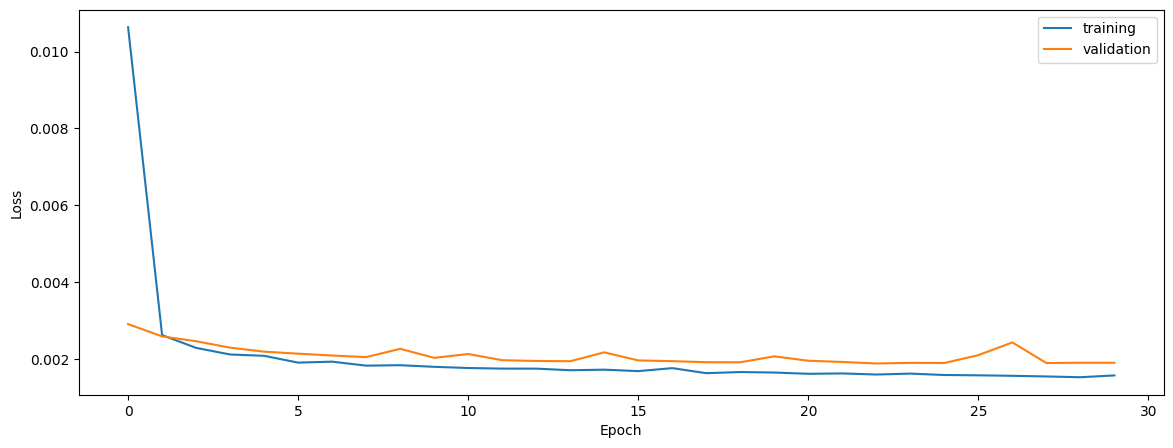

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9347439705655105
0.9330379688516754
0.9362243295783693


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.9342972891936071
0.9456143048814446
0.9445106613389922


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.9391276472624862
0.9481136533168217
0.9523348292378128


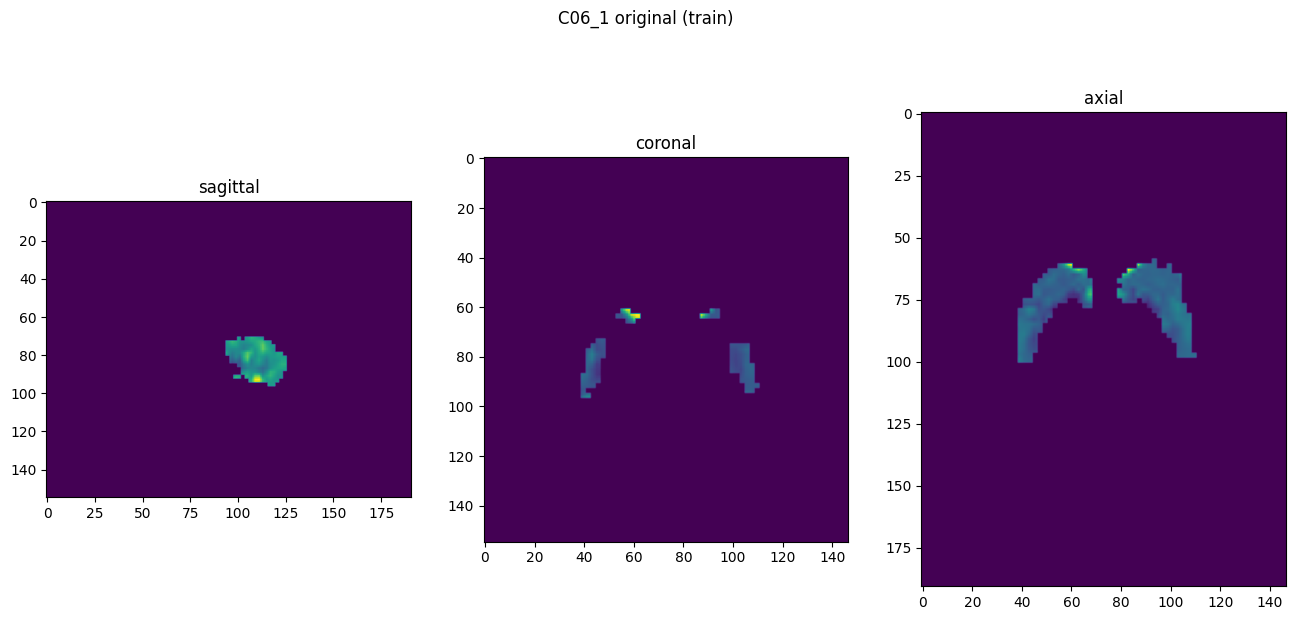

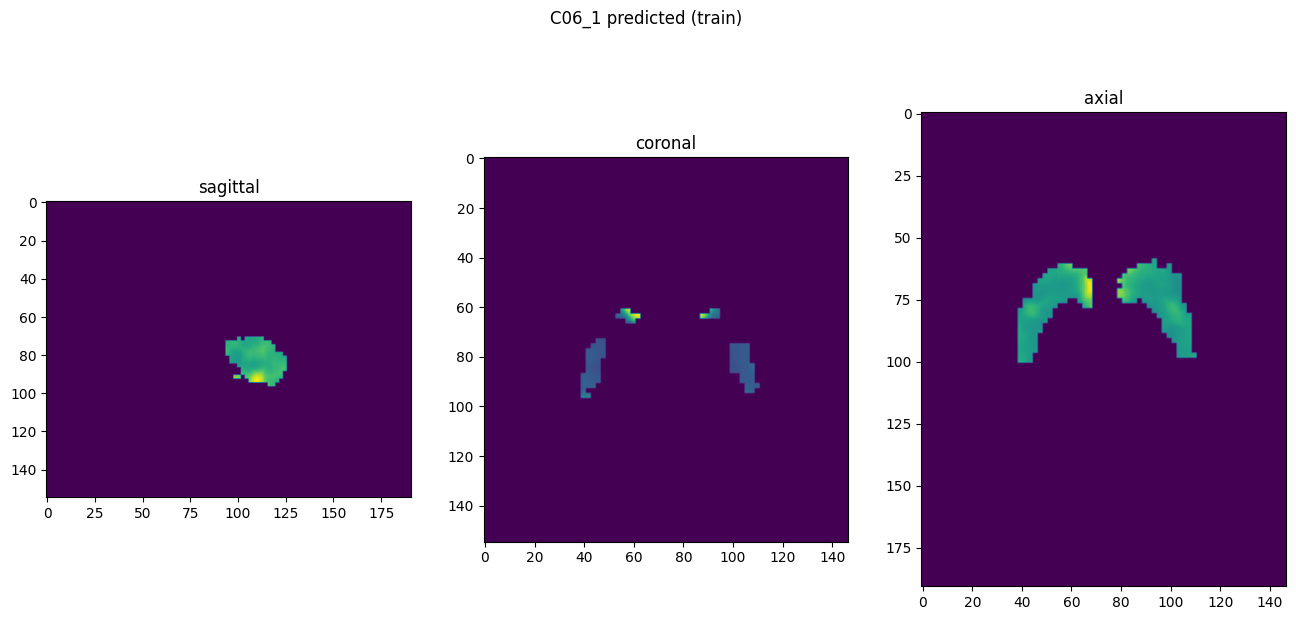

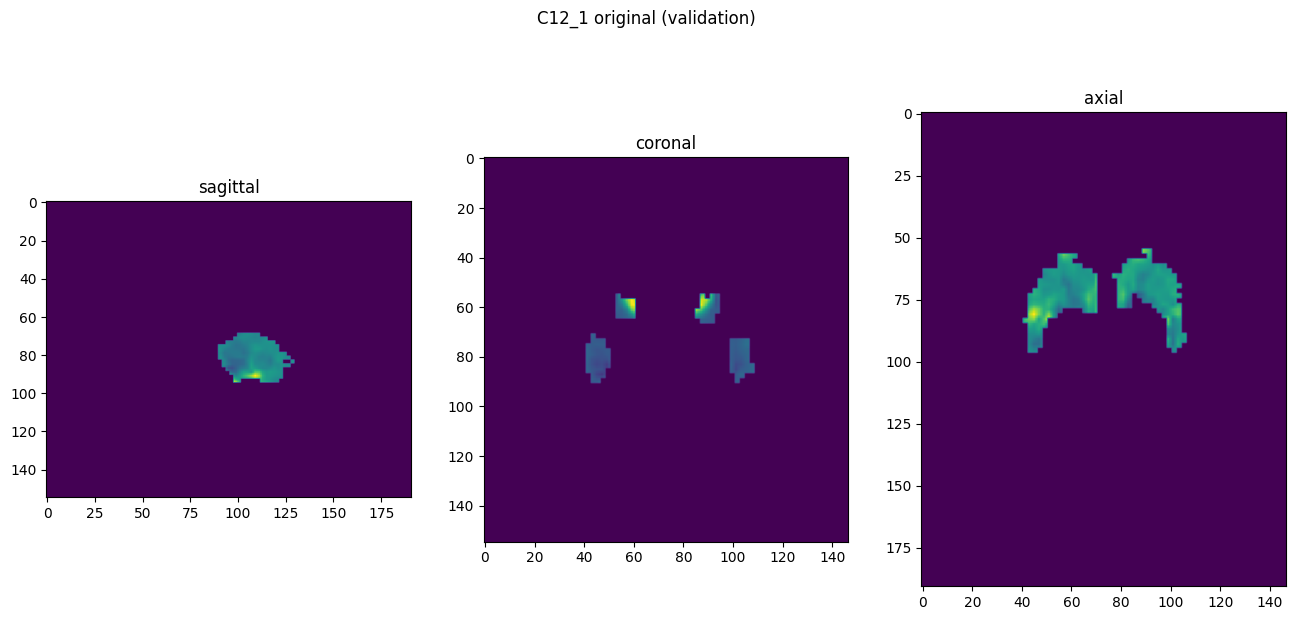

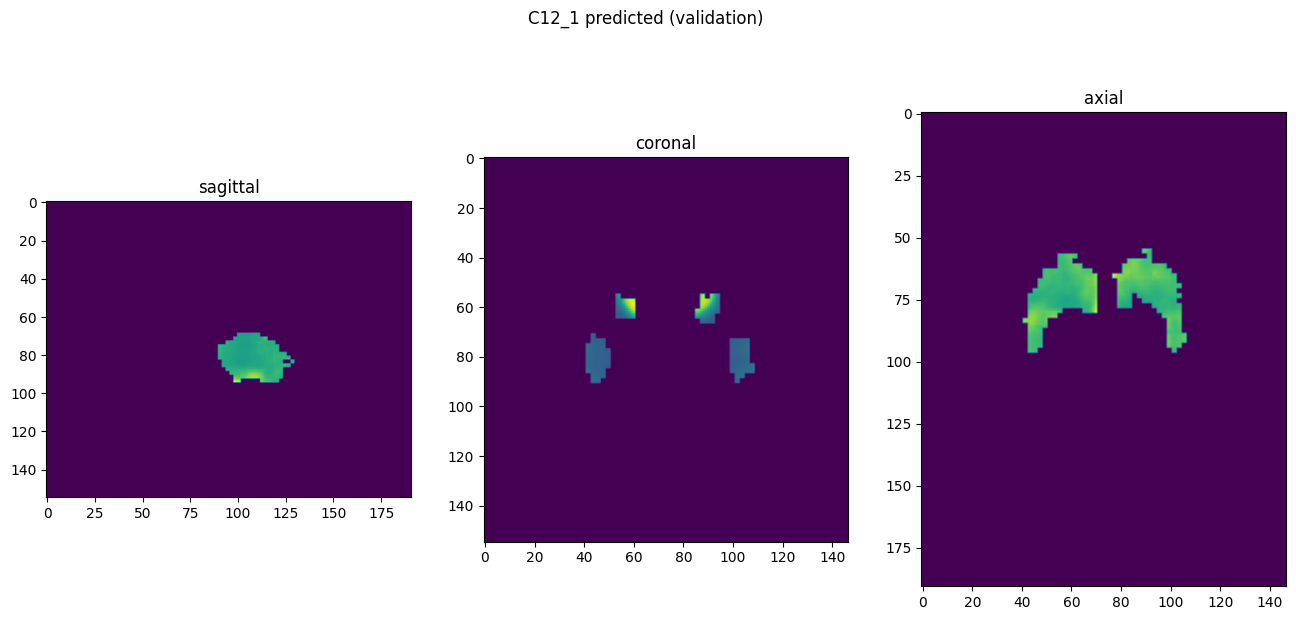

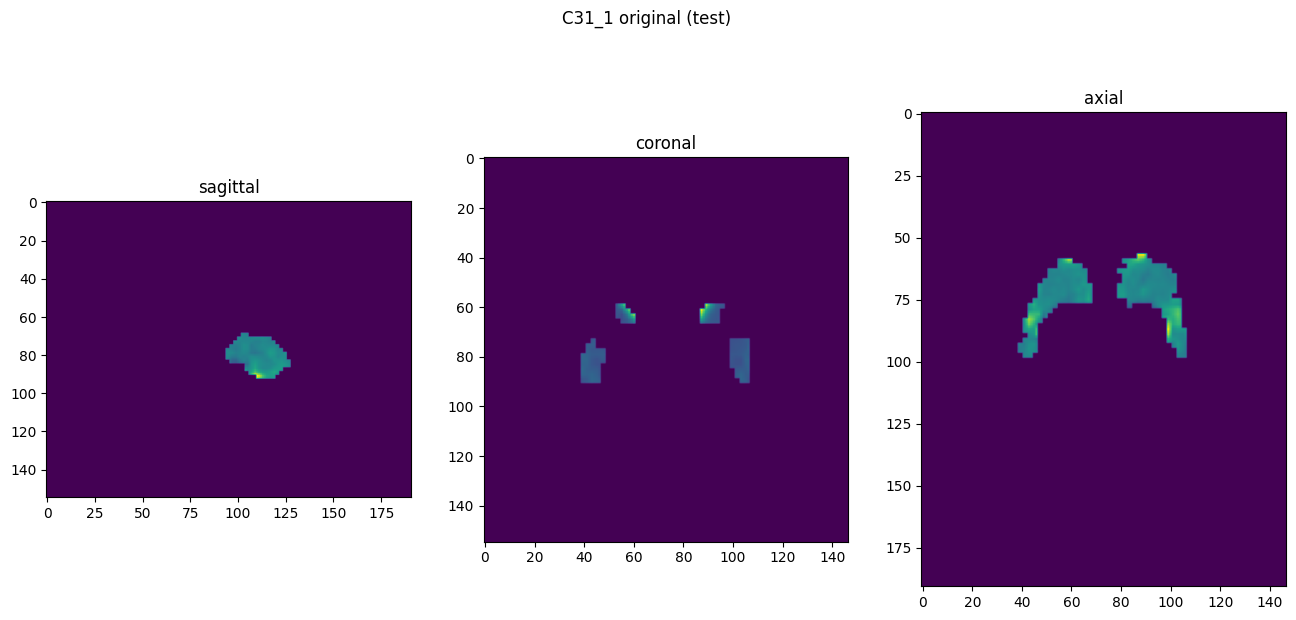

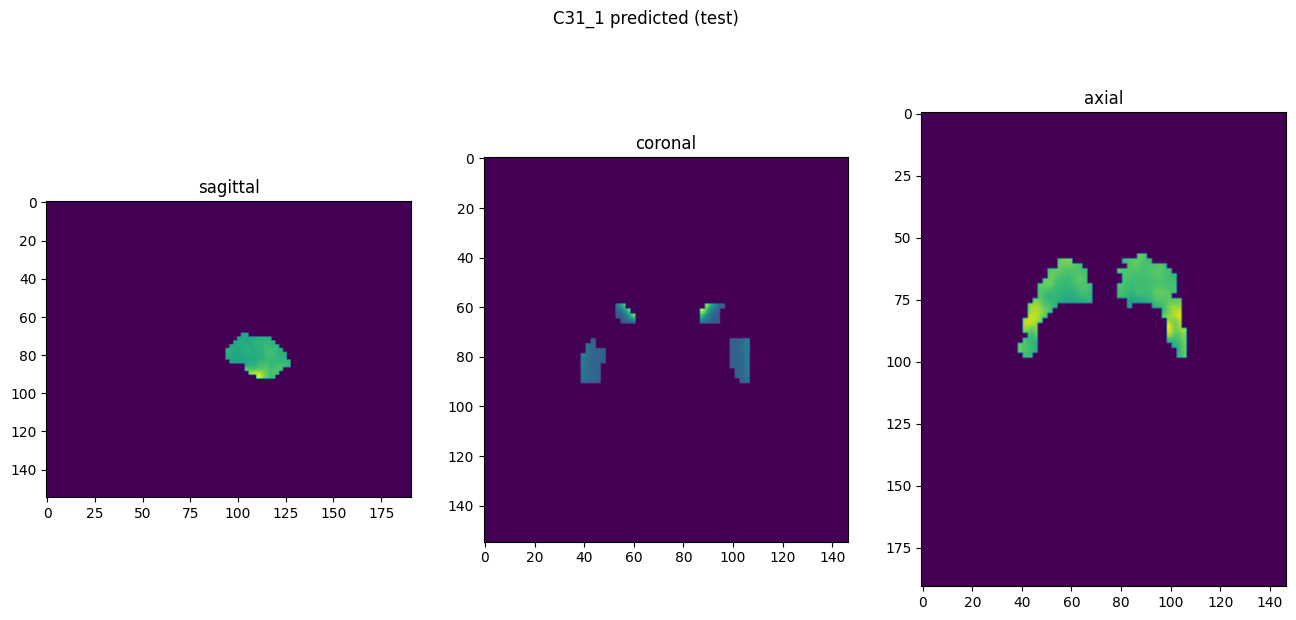

In [10]:
showResults(model, gen, threshold=None, background=False)